# Filters

## Load and plot the image

In [102]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
import cv2

'\n# Show in cv2 window\ncv2.imshow("Zebra", img)\ncv2.waitKey(0)\n'

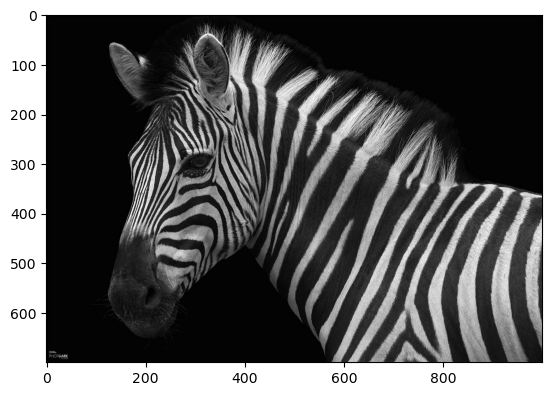

In [103]:
img = cv2.imread('Zebra.jpg', cv2.IMREAD_GRAYSCALE) 
plt.imshow(img, cmap="grey")

"""
# Show in cv2 window
cv2.imshow("Zebra", img)
cv2.waitKey(0)
"""

### Convert the image to binary image

In [104]:
def to_binary(img, treshold=170):
    return (img > treshold).astype(int)
    

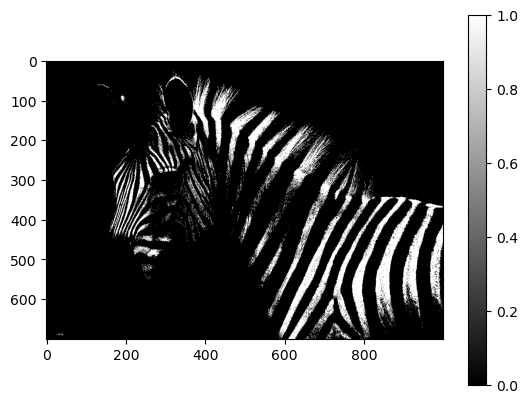

In [105]:
binarized = to_binary(img, 170)
plt.imshow(binarized, cmap="grey")
plt.colorbar()

### Implement the dilation method

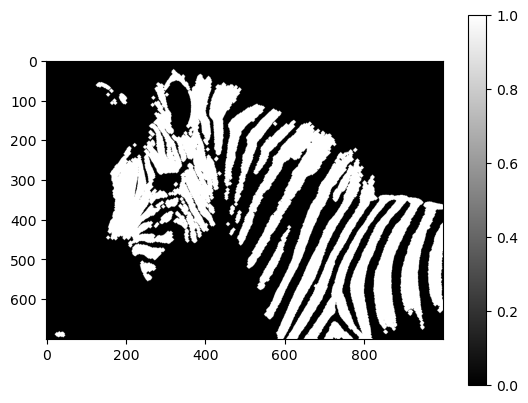

In [132]:
def apply_small_cross_kernel(img, func):
    padded_img = np.pad(img, pad_width=1, mode='constant', constant_values=0)
    
    dilated_img = np.zeros(img.shape, dtype=int)

    for i, row in enumerate(padded_img[1:-1], start=1):
        for j, val in enumerate(row[1:-1], start=1):
            neighbors = [
                padded_img[i-1, j],
                row[j-1],
                val,
                row[j+1],
                padded_img[i+1, j]
            ]
            dilated_img[i-1, j-1] = func(neighbors)
    return dilated_img


def apply_dilation_kernel(img):
    img = apply_small_cross_kernel(img, np.max)
    return img


def apply_repeated(img, func, iterations=5):
    for _ in range(iterations):
        img = func(img)

    return img



dilated = apply_repeated(binarized, apply_dilation_kernel, 5)
plt.imshow(dilated, cmap="grey")
plt.colorbar()

### Implement the erosion method

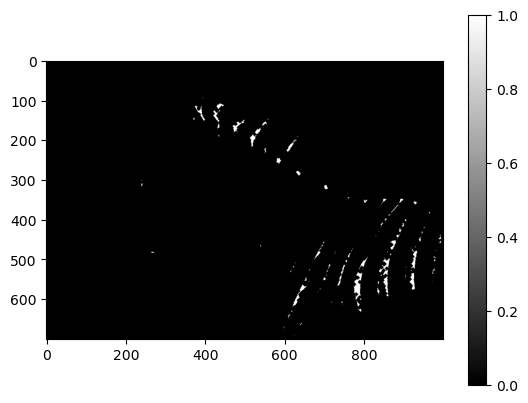

In [107]:
def apply_erosion_kernel(img):
    img = apply_small_cross_kernel(img, np.min)
    return img


dilated = apply_repeated(binarized, apply_erosion_kernel, 5)
plt.imshow(dilated, cmap="grey")
plt.colorbar()

## Opening and Closing

In [108]:
import random
import copy

def add_noise(binary_image, max_noise_elements=50, max_noise_size=1):
    dc_img = copy.deepcopy(binary_image)
    
    h, w = binary_image.shape
    
    for i in range(max_noise_elements):
        # random row
        rand_row = random.randint(0, h)
        rand_col = random.randint(0, w)
        
        # random cluster (like a kernel)
        left = max(0, rand_row - max_noise_size)
        top = max(0, rand_col - max_noise_size)
        right = min(w-1, rand_row + max_noise_size)
        bottom = min(h-1, rand_col + max_noise_size)
        
        # only if no neighbor is already filled with 1s
        if dc_img[top:bottom, left:right].sum() == 0:
            for height in range(top, bottom):
                for width in range(left, right):
                    val = random.randint(0, 1)
                    dc_img[height, width] = val
        
    return dc_img

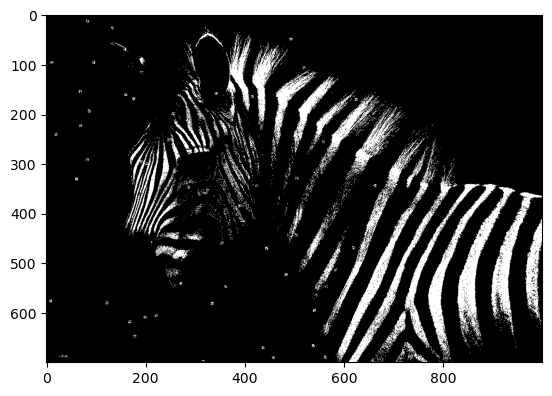

In [109]:
noised = add_noise(binarized, 100, 3)
plt.imshow(noised, cmap="grey")

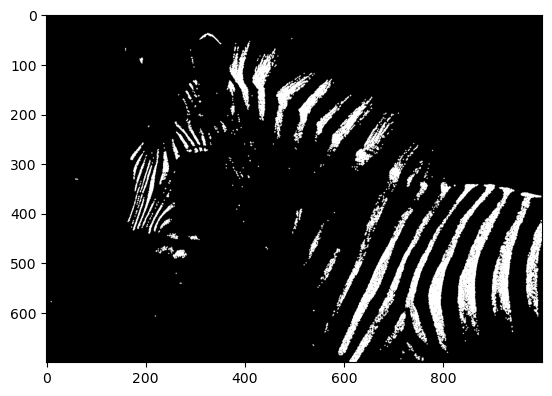

In [110]:
def opening(img, iteratons):
    img = apply_repeated(img, apply_erosion_kernel, iteratons)
    img = apply_repeated(img, apply_dilation_kernel, iteratons)
    
    return img


denoised = opening(noised, 1)
plt.imshow(denoised, cmap="grey")

### Did you find some artefacts? If so, what do you think where these artefacts came from?

When using larger noise particles, the opening needs more iterations to eliminate them all. But it also eliminates smaller contrasting areas in the foreground.

## Gabor filters

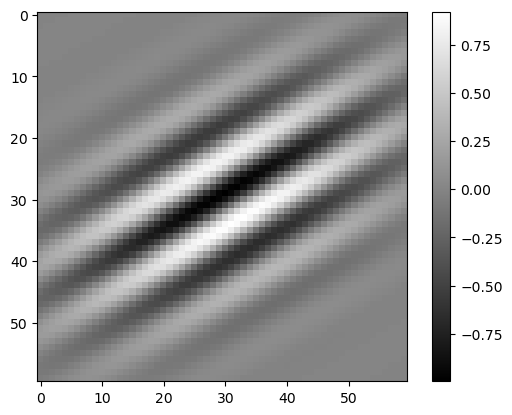

In [111]:
def create_gabor_filter(size, lmbda=10, theta=30, omega=10, sigma=10, gamma=0.5):
    theta = np.radians(theta)

    center_coor = size // 2
    xx, yy = np.mgrid[:size, :size]
    xx -= center_coor
    yy -= center_coor

    x_prime = xx * np.cos(theta) + yy * np.sin(theta)
    y_prime = -xx * np.sin(theta) + yy * np.cos(theta)

    exp_part = np.exp(
        -(x_prime ** 2 + gamma ** 2 * y_prime ** 2) / (2 * sigma ** 2)
    )
    cos_part = np.cos(2 * np.pi * (x_prime / lmbda) + omega)
    return exp_part * cos_part


small_filter = create_gabor_filter(60)
plt.imshow(small_filter, cmap="grey")
plt.colorbar()


### Plot the gabor filter(s) with different parameters to understand how they work

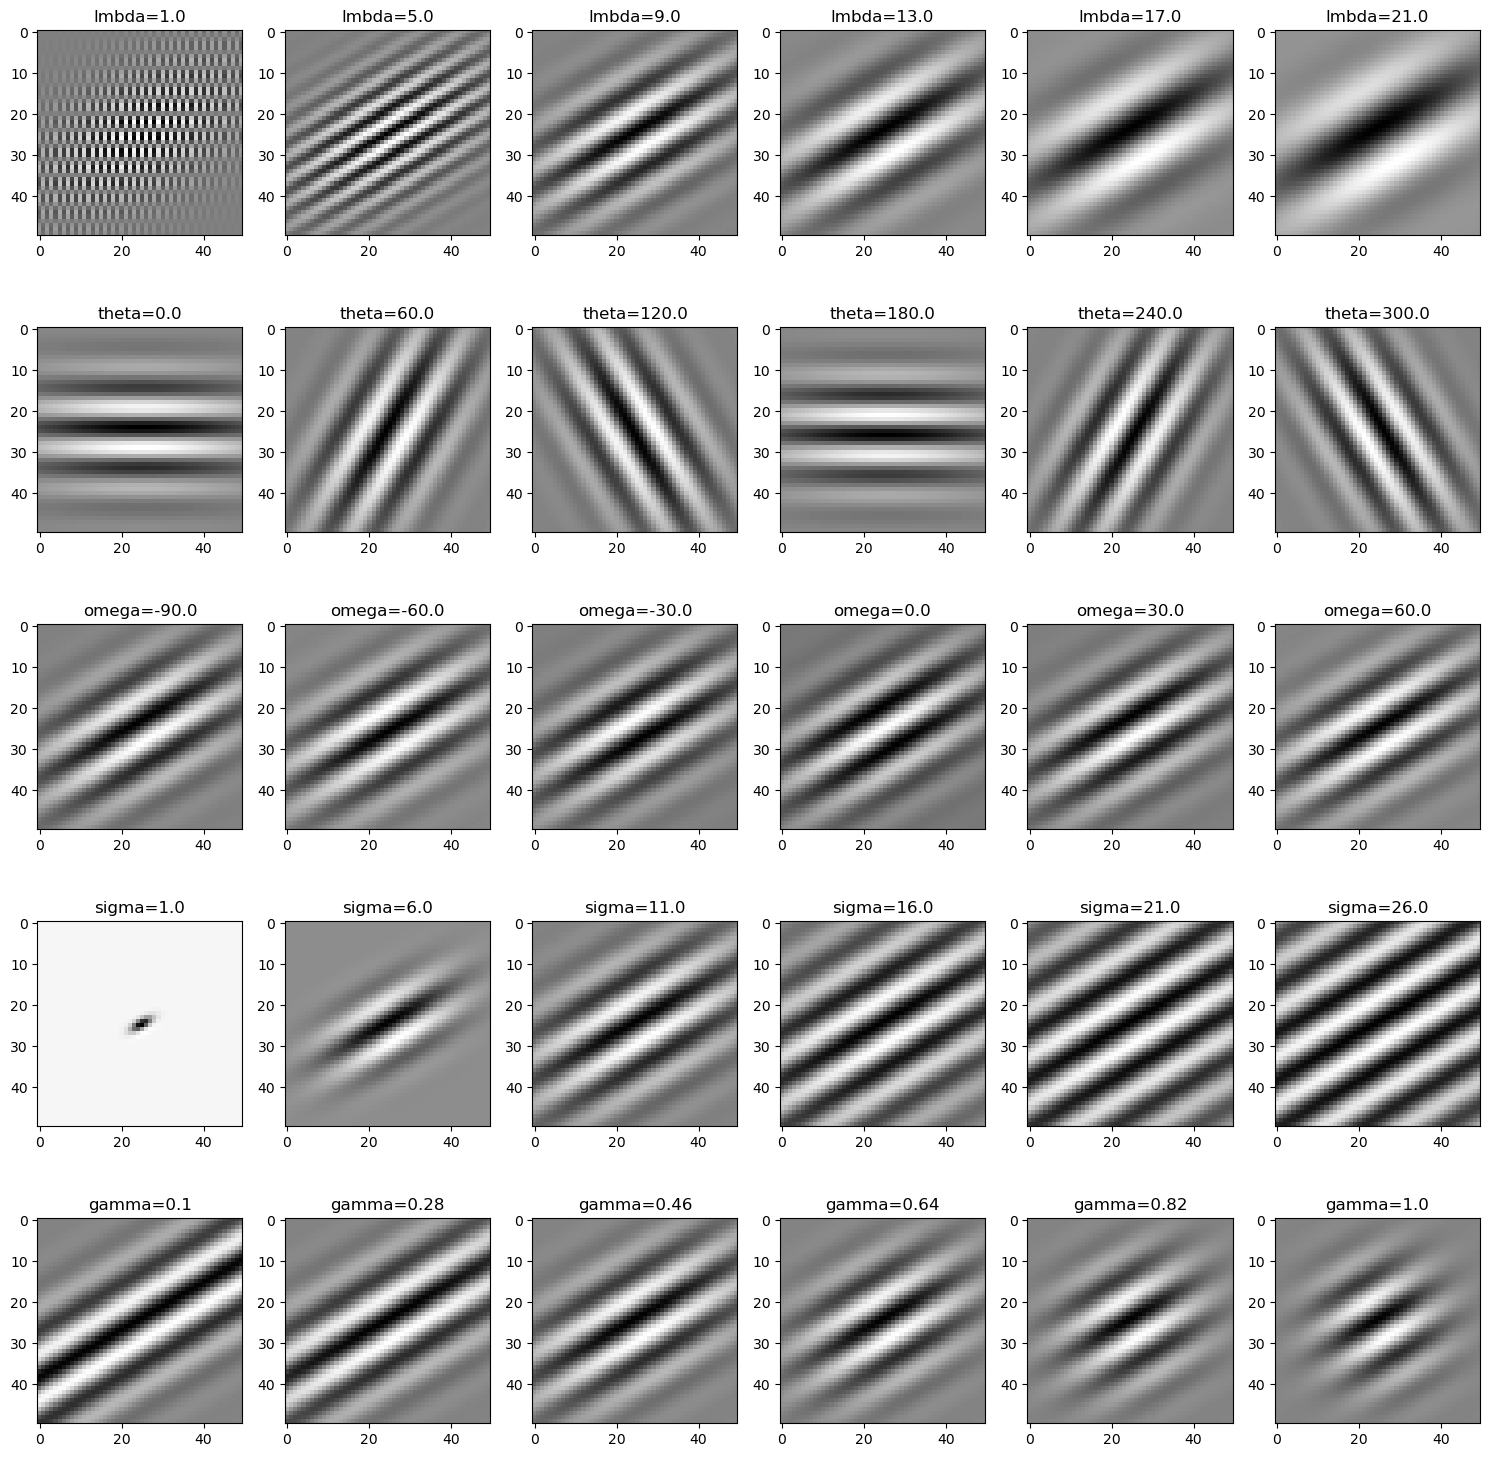

In [112]:
gabor_filter_size = 50
parameters = {
    "lmbda": np.linspace(1, 21, 6),
    "theta": np.linspace(0, 300, 6),
    "omega": np.linspace(-90, 60, 6),
    "sigma": np.linspace(1, 26, 6),
    "gamma": np.linspace(0.1, 1, 6)
}

fix, axs = plt.subplots(len(parameters), len(parameters["gamma"]), figsize=(15, 15))
for ax_row, (param_name, par_values) in enumerate(parameters.items()):
    for ax_col, par_value in enumerate(par_values):
        
        gabor_filter = create_gabor_filter(gabor_filter_size, **{param_name: par_value})
        axs[ax_row, ax_col].imshow(gabor_filter, cmap="grey")
        axs[ax_row, ax_col].set_title(f"{param_name}={np.round(par_value, 3)}")

plt.tight_layout()

### Write a function that applies a gabor filter to an image of your choice (consider using the inital zebra image in both color and greyscale representation)

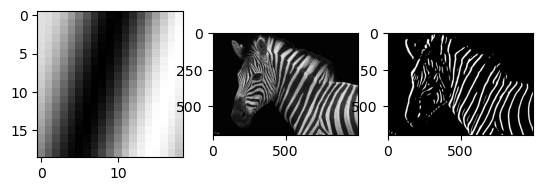

In [113]:
gabor_filter_size = 19
gabor_filter = create_gabor_filter(gabor_filter_size, theta=75, lmbda=20, gamma=0.2)
plt.subplot(1, 3, 1)
plt.imshow(gabor_filter, cmap="grey")

plt.subplot(1, 3, 2)
plt.imshow(img, cmap="grey")
img_after_gabor = cv2.filter2D(img, -1, gabor_filter)
plt.subplot(1, 3, 3)
plt.imshow(img_after_gabor, cmap="grey")

## Filter bank

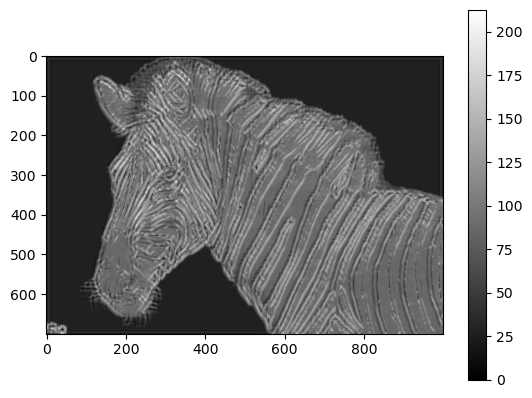

In [ ]:
filterbank = [
    create_gabor_filter(gabor_filter_size, theta=_theta, lmbda=_lmbda, gamma=0.2) for _theta in (0, 45, 90, 135) for _lmbda in (1, 12, 10)
]

filtered_images = [cv2.filter2D(img, -1, gabor) for gabor in filterbank]
superposition = np.mean(filtered_images, axis=0)

plt.imshow(superposition, cmap="grey")
plt.colorbar()

#### Use a second rgb image and repeat your filter bank. Is it still working appropriately?

In [114]:
from matplotlib import image as mpimg

In [118]:
img_colors = mpimg.imread('Zebra.jpg') 
red, blue, green = (img_colors[:, :, 0], img_colors[:, :, 1], img_colors[:, :, 2])

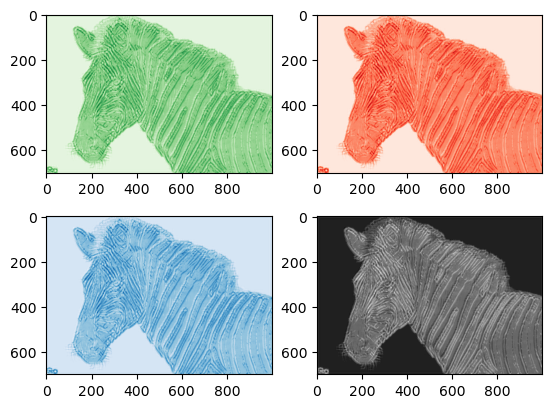

In [130]:

filterbank = [
    create_gabor_filter(gabor_filter_size, theta=_theta, lmbda=_lmbda, gamma=0.2) for _theta in (0, 45, 90, 135) for _lmbda in (1, 12, 10)
]

filtered_images_red = [cv2.filter2D(red, -1, gabor) for gabor in filterbank]
superposition_red = np.mean(filtered_images_red, axis=0)

filtered_images_blue = [cv2.filter2D(blue, -1, gabor) for gabor in filterbank]
superposition_blue = np.mean(filtered_images_blue, axis=0)

filtered_images_green = [cv2.filter2D(green, -1, gabor) for gabor in filterbank]
superposition_green = np.mean(filtered_images_green, axis=0)

plt.subplot(2, 2, 1)
plt.imshow(superposition_green, cmap="Greens")

plt.subplot(2, 2, 2)
plt.imshow(superposition_red, cmap="Reds")

plt.subplot(2, 2, 3)
plt.imshow(superposition_blue, cmap="Blues")

plt.subplot(2, 2, 4)
plt.imshow(np.mean((superposition_green, superposition_blue, superposition_red), axis=0), cmap="gray")